# Resolvendo numericamente a equação de Schrödinger

* PET - Física UFRN
* Petiano: Gabriel Wendell Celestino Rocha
* Data: 17 de Julho de 2020

Nosso objetivo neste `Notebook` é encontrar uma solução puramente numérica para a Equação de Schrödinger independente do tempo (SE).

$$-\frac{\hbar^{2}}{2m}\frac{d^{2}}{dx^{2}}\psi(x)+V(x)\psi(x)=E\psi(x)$$

No processo, espero convencê-lo, de que a SE é uma equação própria. Além disso, este `Notebook` pode ser facilmente modificado para qualquer outro potencial que você queira experimentar.

## Método

O método que usaremos aqui é chamado de ["Método das Diferenças Finitas"](http://sgpwe.izt.uam.mx/files/users/uami/mlss/documentos/LeVequeRJ.pdf) (consulte a referência [4] vinculada para mais informações). Neste método, transformaremos a função $ \psi (x) $ em um vetor, que é uma lista em Python, e o operador da equação diferencial em uma matriz. Em seguida, terminamos com uma equação de matriz, que podemos diagonalizar para obter nossa resposta.

## Discretização

O processo de discretização é simplesmente transformar nosso espaço contínuo $x$, em um número discreto de etapas, $ N $, e nossa função $\psi (x)$ em uma matriz de tamanho $ N $. Portanto, temos $N$ valores de $x_i$, que possuem um tamanho escalonado $ h = \Delta x = x_ {i + 1} - x_i $. Nossa escolha do tamanho do nosso espaço, $ N $, acaba sendo de grande importância. <br>
Um número muito grande desacelerará nossa computação e exigirá muita memória do computador, um número muito pequeno e as respostas que computamos não serão suficientemente precisas. Uma prática comum é começar com um pequeno número $ N $ e aumentá-lo até que a precisão seja aceitável. O valor real obtido no final dependerá do problema que você está estudando.

## Diferencial de primeira ordem para frente e para trás

Primeiro precisamos desenvolver como tomaremos a derivada de nossa função. Voltando à nossa introdução ao cálculo, lembramos que a derivada foi definida como: 

$$\frac{d}{dx}f(x)=\lim_{\Delta x\rightarrow0}\frac{f(x+\Delta x)-f(x)}{\Delta x}\approx\frac{f(x+h)-f(x)}{h}+\mathrm{O}(h)$$ 

Quando assumimos uma diferença finita , simplesmente não reduzimos o limite para 0, mas paramos em $\Delta x=h$. Observe que, para esta equação, avaliamos o ponto logo após $x$, que chamamos de diferença direta. Se você realmente deixar $\Delta x\rightarrow0$, isso não importa, mas se você fizer uma diferença finita, também poderá:

$$\frac{d}{dx}f(x)=\lim_{\Delta x\rightarrow0}\frac{f(x)-f(x-\Delta x)}{\Delta x}\approx\frac{f(x)-f(xh)}{h}+\mathrm{O}(h),$$

que é conhecida como diferença retroativa.

Você também pode calcular uma diferença central, mas não pode usar as etapas de $\frac{1}{2}\Delta x$, pois isso não existe em nosso espaço. A diferença central é então uma combinação dos dois anteriores: 

$$\frac{d}{dx}f(x)=\lim_{\Delta x\rightarrow0}\frac{f(x+\Delta x)-f(x-\Delta x)}{2\Delta x}\approx\frac{f(x+h)-f(xh)}{2h}+\mathrm{O}(h^2)$$

Este último é um pouco mais preciso que os dois primeiros.

Observe que, para qualquer uma dessas aproximações a uma derivada, temos um problema nas bordas do nosso espaço. (Em Python, C, C++ e  C#, nosso espaço varia de $n=0$ a $n=N-1$, já em Fortran ele irá variar de $n=1$ a $n=N$.) De um lado ou de outro, não há $x-\Delta x$ ou $x+\Delta x$. Pelo menos aqui, não vamos nos preocupar com esse detalhe.

### Representação matricial

Agora desejamos transformar a equação em uma equação matricial para avaliarmos. Se você deseja apenas obter a derivada de uma função armazenada em uma matriz, isso não é necessário, você pode executar um loop e avaliar a equação para cada $x_i$, mas se quiser resolver uma equação diferencial, precisamos do matriz. <br>

Inicialmente, introduzimos os vetores $f(x)=[f_0,f_1,f_2,\ldots,f_{N-1}]$ e para a derivada $f'(x)=[f'_0,f'_1,f'_2,\ldots,f'_{N-1}]$. A derivada da diferença progressiva pode então ser escrita como: 

$$f'_i=\frac{f_{i+1}-f_i}{h}$$ 

E a equação da matriz para a derivada da diferença direta é apenas:

$$\begin{pmatrix}
f '_0 \\ 
f'_1 \\
\vdots \\ 
f'_{N-1} \end{pmatrix}=\frac{1}{h} 
\begin{pmatrix} -1 & 1 & 0 & \ldots \\
0 & -1 & 1 & \ldots  \\ 
\ddots & \ddots &  \ddots & \vdots \\
\ldots & \ldots & \ldots & -1 & \text{} \end{pmatrix} 
\begin{pmatrix}f_0 \\
f_1 \\
\vdots \\
f_ {N-1} \end{pmatrix}$$

Note que a última entrada na matriz não estará correta porque não há elemento para $N$. Podemos consertar isso tomando a derivada reversa no último ponto.

Agora verificaremos que isso funciona. Usando a biblioteca `Numpy` do Python, pegaremos a derivada de $\sin(x)$ e plotaremos o resultado.

### Importando as bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl

# Para que essa cell-magic (ou inline-magic) funcione corretamente, execute 
# essa célula duas vezes.
%matplotlib notebook

Vamos usar uma magic extension `%version_information` do `IPython` para gerar um quadro com as informações sobre quais versões das bibliotecas que foram usadas para executar este `Notebook`.
Você pode instalar a extensão `%version_information` usando o `pip` executando o seguinte comando no CMD (prompt de comando) :

`pip install version_information`

In [3]:
%load_ext version_information
%version_information scipy, numpy, matplotlib

Software versions
Python 3.7.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.10.0
OS Windows 10 10.0.18362 SP0
scipy 1.4.1
numpy 1.17.4
matplotlib 3.1.2
Thu Oct 29 21:43:32 2020 Hora Padrão de Buenos Aires

Vamos primeiramente definir o número $N$ de pontos em nosso espaço, em seguida vamos definir o espaço $x$ variando de $0$ até $a$ com $N-1$ divisões, isso pode facilmente ser feito com a função `linspace()` da biblioteca `Numpy` do Python (cheque a documentação do `Numpy` [aqui](https://numpy.org/doc/)). Após isso, vamos armazenar o tamanho do passo (pois essa é a maneira confiável) e finalizar computando a função $y=\sin(x)$.

In [4]:
N = 128
pi = np.pi
a = 2*pi

x = np.linspace(0, 2*pi, N)
h = x[1] - x[0] # Que deve ser igual a 2*pi/(N-1)
y = np.sin(x)

Calculamos a matriz usando o `np.diag(np.ones(N),0)` que cria uma matriz diagonal 1 do tamanho $N\times N$. Para isso, basta multiplicar por -1 para obter a matriz diagonal -1. Você pode obter uma matriz fora da diagonal +1, com o comando `np.diag(np.ones(N-1),1)`. Observe que você precisa de $N-1$ para uma matriz $N\times N$.

Vamos agora adicionar os dois conjuntos e normalizar por $\frac{1}{h}$ e em seguida calcular a derivada de $y$ em $y_{p}$ pela multiplicação da matriz.

In [5]:
Md = 1./h*(np.diag(-1.*np.ones(N),0) + np.diag(np.ones(N-1),1))
yp = Md.dot(y)

Vamos agora criar uma função para melhorar a estética dos nossos plots (experimente realizar os plots com e sem o auxílio de nossa função para ver a diferença!).

In [6]:
def opt_plot():
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                    top = True,right = True, length=5,width=1,
                    labelsize=15)
    plt.tick_params(axis='both',which='major', direction = "in",
                    top = True,right = True, length=8,width=1,
                    labelsize=15)

Agora vamos plotar o resultado! 

$\textbf{OBS}:$ Não plote o último valor, pois o mesmo é inválido!

<IPython.core.display.Javascript object>


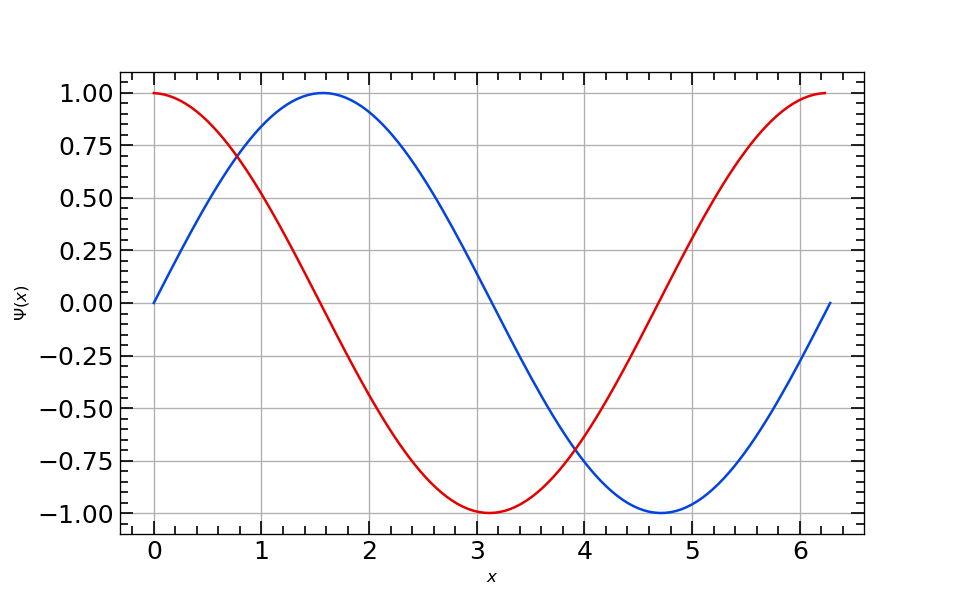

In [7]:
plt.figure(figsize=(8,5))
plt.plot(x,y, color = 'xkcd:blue')
plt.plot(x[:-1],yp[:-1], color = 'xkcd:red')
plt.xlabel("$x$")
plt.ylabel("$\Psi(x)$")
plt.show()
plt.grid()

opt_plot()

Caso você deseje armazenar os plots de forma automática, você pode usar o comando `plt.savefig('<nome do arquivo>.<extensão>')` (você pode checar melhor essa função [aqui](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.savefig.html)). Nesse caso, o plot ficará armazenado na pasta (ou no endereço) no qual estará o arquivo do programa. 

## Diferencial de Segunda Ordem

Agora podemos estender esse método para o diferencial de segunda ordem. Se tomarmos o diferencial para trás do resultado de um diferencial para frente, obtemos:

$$\frac{d^2}{dx^2}f(x)=\lim_{\Delta x\rightarrow0}\frac{f'(x)-f'(x-\Delta x)}{\Delta x}=\lim_{\Delta x\rightarrow0}\frac{f(x+\Delta x)-f(x)-(f(x)-f(x-\Delta x))}{\Delta x^2}$$

$$\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0}\frac{f(x+\Delta x)-2f(x)+f(x-\Delta x))}{\Delta x^2}\approx\frac{f(x+h)-2f(x)+f(x-h))}{h^2}$$

Portanto, no espaço discreto, podemos escrever isso como:

$$f''_{i}\text{ }=\text{ }\frac{(f_{i+1}-2f_{i}+f_{i-1})}{h^2}$$

E finalmente, como uma equação matricial, a segunda derivada é então:

$$\begin{pmatrix}
f''_0 \\ 
f''_1 \\
\vdots \\ 
f''_{N-1} \end{pmatrix}=\frac{1}{h^2} 
\begin{pmatrix} -2 & 1 & 0 & 0 & \ldots \\
1 & -2 & 1 & 0 & \ldots  \\
0 & 1 & -2 & 1 & \ldots \\
\ddots & \ddots &  \ddots & \ddots & \vdots \\
\ldots & \ldots & \ldots & 1 & -2 & \text{} \end{pmatrix} 
\begin{pmatrix}f_0 \\
f_1 \\
\vdots \\
f_ {N-1} \end{pmatrix}$$

Onde agora observamos que nas duas extremidades da nossa matriz obteremos uma resposta imprecisa, a menos que façamos alguma correção. A correção nesse caso é usar os mesmos elementos da linha abaixo (no início) ou da linha acima (no final), para obtermos $ f''_{0}=f''_{1}$ e $f''_{N-1}=f''_{N-2}$, o que não é ótimo, mas melhor que a alternativa.

Agora podemos tentar essa matriz em Python e calcular a segunda derivada de nossa matriz $ y(x)$.

In [8]:
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) + np.diag( -2.*np.ones(N),0) + 
                np.diag(np.ones(N-1),1))
print(Mdd)

[[-817.10468548  408.55234274    0.         ...    0.
     0.            0.        ]
 [ 408.55234274 -817.10468548  408.55234274 ...    0.
     0.            0.        ]
 [   0.          408.55234274 -817.10468548 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -817.10468548
   408.55234274    0.        ]
 [   0.            0.            0.         ...  408.55234274
  -817.10468548  408.55234274]
 [   0.            0.            0.         ...    0.
   408.55234274 -817.10468548]]


Agora estamos aptos para realizar os plots. 

$\textbf{OBS}:$ No segundo plot, o último valor não deve ser plotado (pois é inválido), já no terceiro plot os valores que não devem ser plotados são o primeiro e o último (pois também são inválidos!) 

<IPython.core.display.Javascript object>


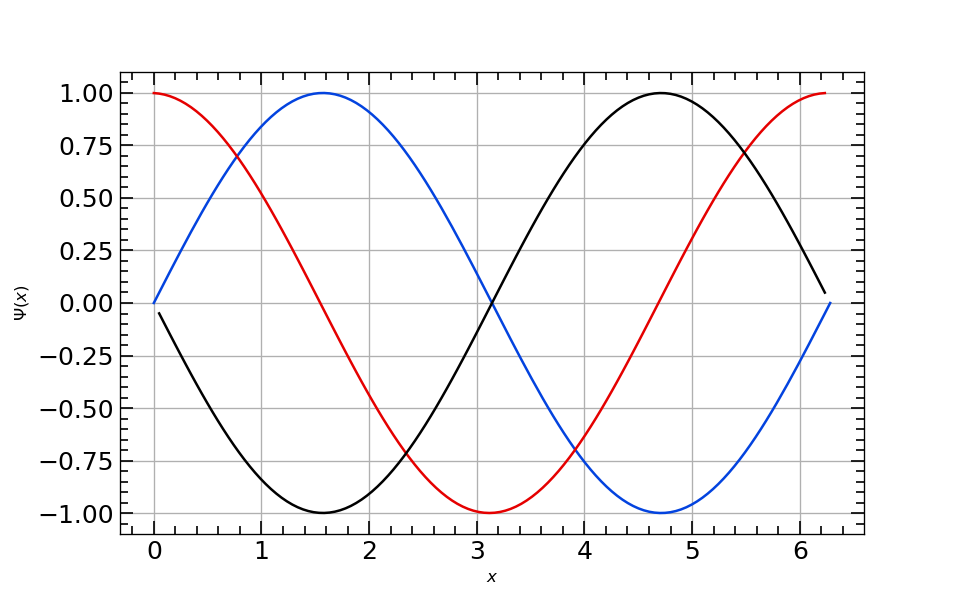

In [9]:
ypp = Mdd.dot(y)

plt.figure(figsize=(8,5))

plt.plot(x,y, color = 'xkcd:blue')
plt.xlabel("$x$")
plt.ylabel("$\Psi(x)$")

plt.plot(x[:-1],yp[:-1], color = 'xkcd:red')

plt.plot(x[1:-1],ypp[1:-1], color = 'xkcd:black')
plt.grid()

opt_plot()

## Resolvendo a equação de Schrödinger

Agora podemos configurar a Equação de Schrödinger como uma equação matricial:

$$\hat H=\frac{\hbar^2}{2m}\frac{d^2}{dx^2}+V\hat H\psi(x)=E\psi(x)$$ 

Agora conhecemos a matriz para obter a derivada de segunda ordem. A matriz para o potencial é simplesmente os valores do potencial na diagonal da matriz: $\mathbf{V}_{i=j}=V_i$.

Escrevendo a matriz para $\mathbf{H}$, obtemos:



$$\mathbf{H}=\frac{-\hbar^{2}}{2mh^{2}}
\begin{pmatrix} -2 & 1 & 0 & 0 & \ldots \\
1 & -2 & 1 & 0 & \ldots  \\
0 & 1 & -2 & 1 & \ldots \\
\ddots & \ddots &  \ddots & \ddots & \vdots \\ 
\ldots & \ldots & \ldots & 1 & -2 & \text{}
\end{pmatrix} + \begin{pmatrix} V_{0} & 0 & 0 & \ldots & \vdots \\
0 & V_{1} & 0 & \ldots & \vdots \\
0 & 0 & V_{2} & \ldots & \vdots \\
\ddots & \ddots &  \ddots & \ddots & \vdots \\
\ldots & \ldots & \ldots & \text{} & V_{N-1} & \text{} \end{pmatrix}$$

Vale a pena examinar a matriz do Hamiltoniano e observar a simetria: $\mathbf{H}^{T}\equiv\mathbf{H}$, ou seja, a matriz transposta é idêntica à matriz original. Como a matriz é *real* em todos os pontos, o seu complexo conjugado também será: $\mathbf{H^{*}}=\mathbf{H}$. Combinando essas duas afirmações, podemos dizer que o hamiltoniano é *hermítico*: $\mathbf{H^{\dagger}}=\mathbf{H}$

## Poço de potencial infinito

O sistema mais simples de se resolver é o [poço de potencial infinito](https://ocw.mit.edu/courses/physics/8-04-quantum-physics-i-spring-2016/lecture-notes/MIT8_04S16_LecNotes11.pdf), para o qual $V=0$. Reconheceremos prontamente os resultados alternando as funções $\cos(x)$ e $\sin(x)$, e os níveis de energia são:

$$E_{i}=\frac{n^{2}\pi^{2}\hbar^{2}}{2ma^{2}}$$

Primeiro, precisamos discutir uma sutileza. O poço de potencial infinito de $-\frac{a}{2}$ até $\frac{a}{2}$ possui $V=\infty$ nesses pontos. Nós teremos problemas ao tentar inserir $\infty$ em nosso potencial, portanto, o que precisamos fazer é limitar o espaço computacional de $-\frac{a}{2}+h$ até $\frac{a}{2}-h$, onde $h$ é o tamanho do nosso passo. Dessa forma, forçamos a função de onda a zero nos pontos finais. 

Inicialmente, vamos criar $x_{full}$ como o eixo completo de $-\frac{a}{2}$ até $\frac{a}{2}$, entretanto, pegue $N+2$ passos. Deixe de fora o primeiro e o último ponto ao calcular as funções de onda. No final, antes de plotar, adicione zero no início e no final das funções de onda, para obter o resultado esperado para plotar.

$\textbf{OBS}$: Irei importar tudo novamente e configurar todas as definições, para que este bloco seja autônomo.

In [10]:
hbar = 1
m = 1
N = 512
a = 1.0
x = np.linspace(-a/2.,a/2.,N)
pi = np.pi

h = x[1]-x[0] # Deve ser igual a 2*pi/(N-1)
V = 0.*x
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) 
                + np.diag(np.ones(N-1),1))

H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 

Agora vamos calcular os autovalores e autovetores com o auxílio da função `np.linalg.eigh()` (para mais informações, clique [aqui](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)). Em seguida, levamos a transposição de `psiT` para os vetores de funções de onda que podem ser acessados como `psi[n]`.

In [11]:
E,psiT = np.linalg.eigh(H) 
psi = np.transpose(psiT)   

Agora, queremos traçar essas funções de onda... 

$\textbf{OBS}:$ Não se esqueça de ativar as funções de onda se for negativo em todo $x$ para que os plots sejam mais consistentes.

<IPython.core.display.Javascript object>


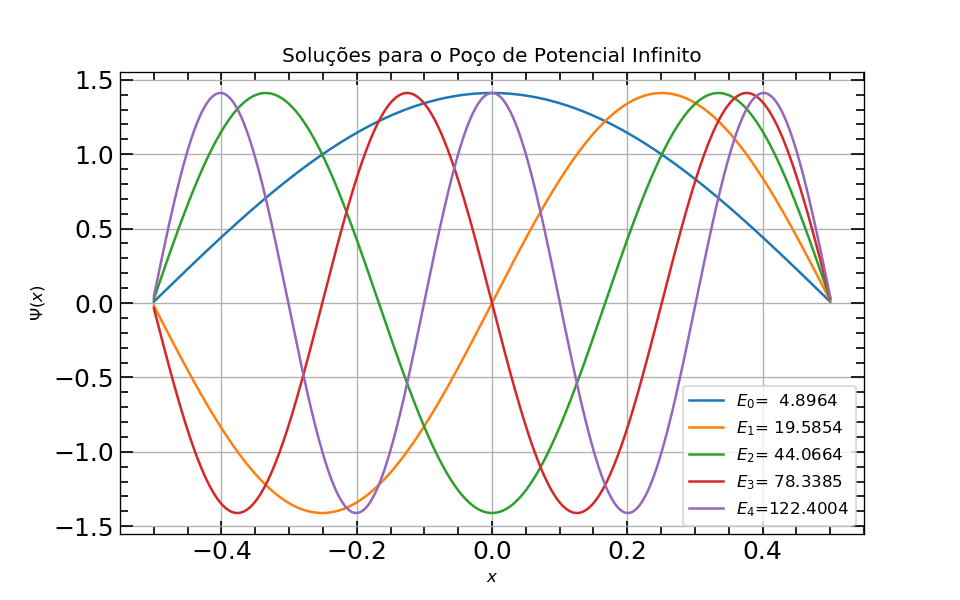

In [12]:
plt.figure(figsize=(8,5))
for i in range(5):
    if psi[i][N-10] < 0:   
        plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:>8.4f}".format(i,E[i]))
    else:
        plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:>8.4f}".format(i,E[i]))
        plt.title("Soluções para o Poço de Potencial Infinito")
        plt.xlabel("$x$")
        plt.ylabel("$\Psi(x)$")
plt.legend()
plt.grid()

opt_plot()
plt.savefig('Soluções para o Poço de Potencial Infinito.png')

Agora, também queremos verificar se os níveis de energia realmente correspondem aos níveis conhecidos:

$$E_{n}=\frac{n^{2}\pi^{2}\hbar^{2}}{2ma^{2}}$$

In [13]:
for i in range(7):
    n = i+1
    print("E[{}] = {:9.4f}, E_{} ={:9.4f}".format(n,E[i],n, n*n*np.pi**2*hbar*hbar/(2*m*a*a)))

E[1] =    4.8964, E_1 =   4.9348
E[2] =   19.5854, E_2 =  19.7392
E[3] =   44.0664, E_3 =  44.4132
E[4] =   78.3385, E_4 =  78.9568
E[5] =  122.4004, E_5 = 123.3701
E[6] =  176.2505, E_6 = 177.6529
E[7] =  239.8868, E_7 = 241.8053


Note que, à medida que $N$ aumenta, os resultados para os níveis de energia se tornam cada vez mais precisos. Valores de $N$ tão altos quanto 1024 ou 20148 ainda dão resultados de forma rápida nos computadores modernos.

Um teste final mostra a precisão de nosso cálculo na ortonormalidade dos estados:

In [14]:
for j in range(5):
    for i in range(5):
        print("{:16.9e}".format(np.sum(psi[j]*psi[i]))),
    print()

 1.000000000e+00
-5.551115123e-17
-3.053113318e-16
 2.775557562e-16
 1.457167720e-16

-5.551115123e-17
 1.000000000e+00
 2.775557562e-16
-3.330669074e-16
-1.249000903e-16

-3.053113318e-16
 2.775557562e-16
 1.000000000e+00
-1.665334537e-16
 2.220446049e-16

 2.775557562e-16
-3.330669074e-16
-1.665334537e-16
 1.000000000e+00
 5.551115123e-17

 1.457167720e-16
-1.249000903e-16
 2.220446049e-16
 5.551115123e-17
 1.000000000e+00



Vamos agora analisar o caso de um potencial linear

### O Potencial Linear

In [15]:
hbar = 1
m = 1
N = 4096
a = 15.0

#### Caso simétrico

Para o caso simétrico, temos o potencial:

$$V(x)=\lambda \left| x \right| = \left\{\begin{matrix} \lambda x,& \mathrm{if\ }& x\ge 0 \\ -\lambda x,& \mathrm{if\ }& x<0 \end{matrix} \right.$$ 

Para o caso unilateral, temos o potencial:

$$V(x) = \left\{\begin{matrix} \lambda x,& \mathrm{if\ }& x\ge 0 \\ \infty,& \mathrm{if\ }& x<0 \end{matrix} \right.$$

Definimos $\lambda=1$ quando fazemos os cálculos. Observe que, para obter o potencial indo para $\infty$, precisamos definir o eixo $x$ para ir de 0. a $\frac{a}{2}$ com $\frac{N}{2}$ pontos, em vez de $-\frac{a}{2}$ a $\frac{a}{2}$ com $N$ pontos.

Esse será para o potencial linear simétrico:

In [16]:
xs = np.linspace(-a/2.,a/2.,N)
Vs = np.abs(xs)

Já esse será para o potencial linear unilateral

In [17]:
xo = np.linspace(0.,a/2.,N/2)
Vo = np.abs(xo)

Vamos plotar o caso simétrico. Para isso, vamos definir a cor dos eixos como sendo preto e vamos plotar o potencial em azul, isso pode ser feito com o auxílio da função `plt.xkcd()` (você pode checar a documentação dessa função [aqui](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xkcd.html))

<IPython.core.display.Javascript object>


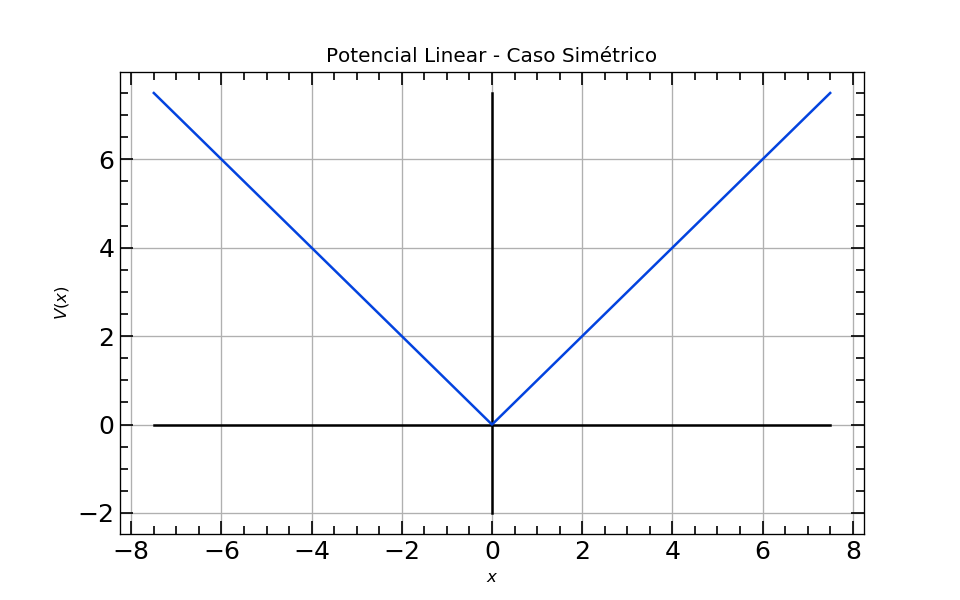

In [18]:
fig1 = plt.figure(figsize=(8,5))

plt.plot([0,0],[-2,a/2.],color = "xkcd:black")  
plt.plot([-a/2.,a/2.],[0,0],color = "xkcd:black")

plt.plot(xs,Vs,color = "xkcd:blue")           
plt.title("Potencial Linear - Caso Simétrico")
plt.xlabel("$x$")
plt.ylabel("$V(x)$")
plt.grid()
opt_plot()

plt.savefig('Potencial Linear - Caso Simétrico.png')

Agora vamos plotar o caso unilateral. Vamos plotar o lado do infinito em vermelho.

<IPython.core.display.Javascript object>


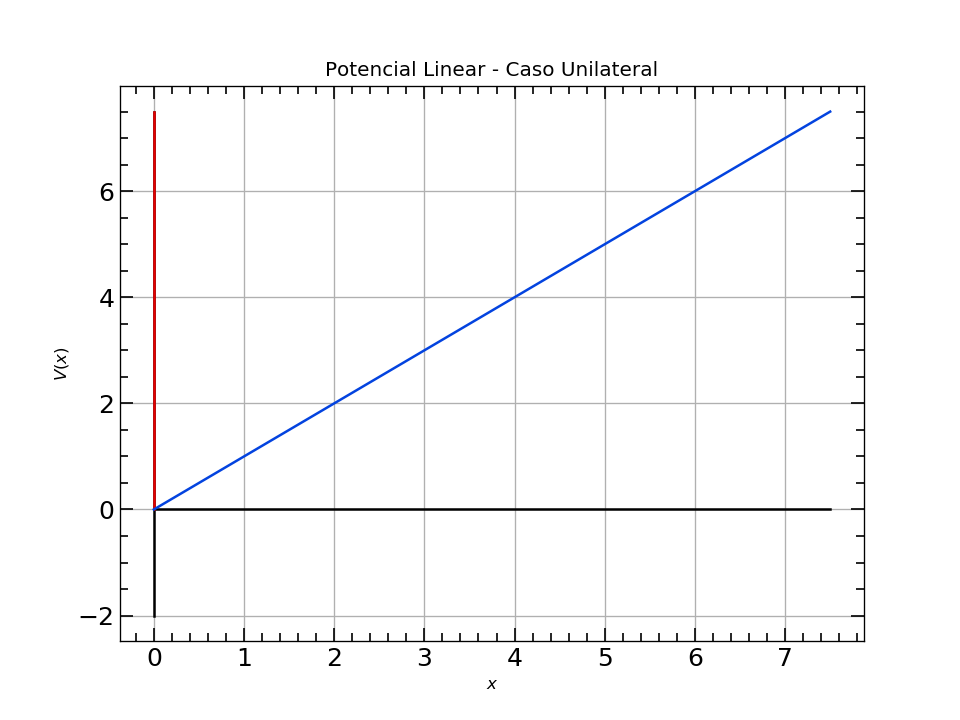

In [19]:
fig1 = plt.figure(figsize=(8,6))

plt.plot([0,0],[-2,a/2.],color = "xkcd:black")

plt.plot([0,a/2.],[0,0],color = "xkcd:black")

plt.plot([0,0],[0,a/2.],color = "xkcd:red") 

plt.plot(xo,Vo,color = "xkcd:blue")
plt.title("Potencial Linear - Caso Unilateral")
plt.xlabel("$x$")
plt.ylabel("$V(x)$")
plt.grid()
opt_plot()

plt.savefig('Potencial Linear - Caso Unilateral.png')

Para cada um dos potenciais, configuramos o Hamiltoniano como uma matriz e, em seguida, usamos um solucionador de matriz para obter os autovalores e autovalores.

$\textbf{OBS}:$ Os autovalores são os níveis de energia desse sistema.

Vamos agora ao caso simétrico.

In [20]:
hs = xs[1]-xs[0] # Deve ser igual à 2*pi/(N-1)
Mdds = 1./(hs*hs)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) 
                   + np.diag(np.ones(N-1),1))
Hs = -(hbar*hbar)/(2.0*m)*Mdds + np.diag(Vs) 

Esse passo irá calcular os autovalores e os autovetores. Nossos autovetores são `psi(i)`, onde $i$ são os níveis de energia.

In [21]:
Es,psiTs = np.linalg.eigh(Hs) 
psis = np.transpose(psiTs)

print(np.sum(psis[0]*psis[0]))  # Note que eles já estão normalizados.

0.9999999999999999


Agora vamos ao caso unilateral (que é análogo ao caso anterior).

In [22]:
ho = xo[1]-xo[0] # Deve ser igual à 2*pi/(N-1)

N_half = int(N/2)
Mddo = 1./(ho*ho)*(np.diag(np.ones(N_half-1),-1) -2* np.diag(np.ones(N_half),0) 
                   + np.diag(np.ones(N_half-1),1))
Ho = -(hbar*hbar)/(2.0*m) * Mddo + np.diag(Vo) 

Eo,psiTo = np.linalg.eigh(Ho) 
psio = np.transpose(psiTo)

print(np.sum(psio[0]*psio[0]))  # Note que eles já estão normalizados.

1.0000000000000007


$\textbf{OBS}:$ A transformação `N_half = int(N/2)` foi feita para evitar o seguinte erro de compilação: `TypeError: 'float' object cannot be interpreted as an integer`

Agora, imprimimos os níveis de energia. Para tornar mais óbvio que os níveis de energia de um potencial unilateral correspondem a todos os outros níveis de energia do caso simétrico, plotamos os unilaterais ao lado do caso simétrico correspondente. À medida que você aumenta o valor de $N$, o acordo entre esses níveis se aproxima.

In [23]:
print("Caso Simétrico  \t Caso Unilateral")
for n in range(12):
    if n%2==1:
        no = int((n-1)/2)
        
        print("Es[{}] = {:9.4f}\t Eo[{}] ={:9.4f}".format(n,Es[n],no, Eo[no]))
    else:
        print("Es[{}] = {:9.4f} ".format(n,Es[n]))

Caso Simétrico  	 Caso Unilateral
Es[0] =    0.8086 
Es[1] =    1.8558	 Eo[0] =   1.8521
Es[2] =    2.5781 
Es[3] =    3.2446	 Eo[1] =   3.2409
Es[4] =    3.8257 
Es[5] =    4.3817	 Eo[2] =   4.3780
Es[6] =    4.8919 
Es[7] =    5.3870	 Eo[3] =   5.3834
Es[8] =    5.8538 
Es[9] =    6.3161	 Eo[4] =   6.3123
Es[10] =    6.7726 
Es[11] =    7.2526	 Eo[5] =   7.2482


$\textbf{OBS}:$ A transformação `no = int((n-1)/2)` foi feita para evitar o seguinte erro de compilação: `# IndexError: only integers, slices (:), ellipsis (...), numpy.newaxis (None) and integer or boolean arrays are valid indices.`

Agora, queremos plotar essas funções de onda.

<IPython.core.display.Javascript object>


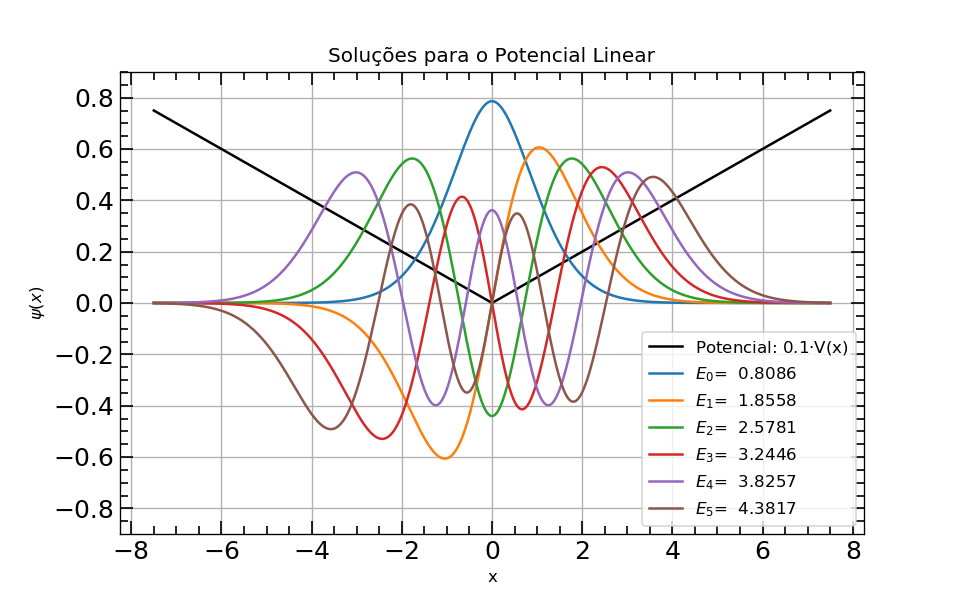

In [24]:
plt.figure(figsize=(8,5))

plt.plot(xs,0.1*Vs,color="black",label="Potencial: 0.1$\cdot$V(x)")
plt.ylim((-0.9,0.9))
for i in range(6):
    if psis[i,N-10]<0:
        plt.plot(xs,-np.real(psis[i])/np.sqrt(hs),label="$E_{}$={:8.4f}".format(i,Es[i]))
    else:
        plt.plot(xs,np.real(psis[i])/np.sqrt(hs),label="$E_{}$={:8.4f}".format(i,Es[i]))
    plt.legend()
    plt.title("Soluções para o Potencial Linear")
    plt.xlabel("x")
    plt.ylabel("$\psi(x)$")
plt.grid()
opt_plot()

plt.savefig('Soluções para o Potencial Linear.png')

Os cinco primeiros níveis de energia desse sistema são dados por:

<IPython.core.display.Javascript object>


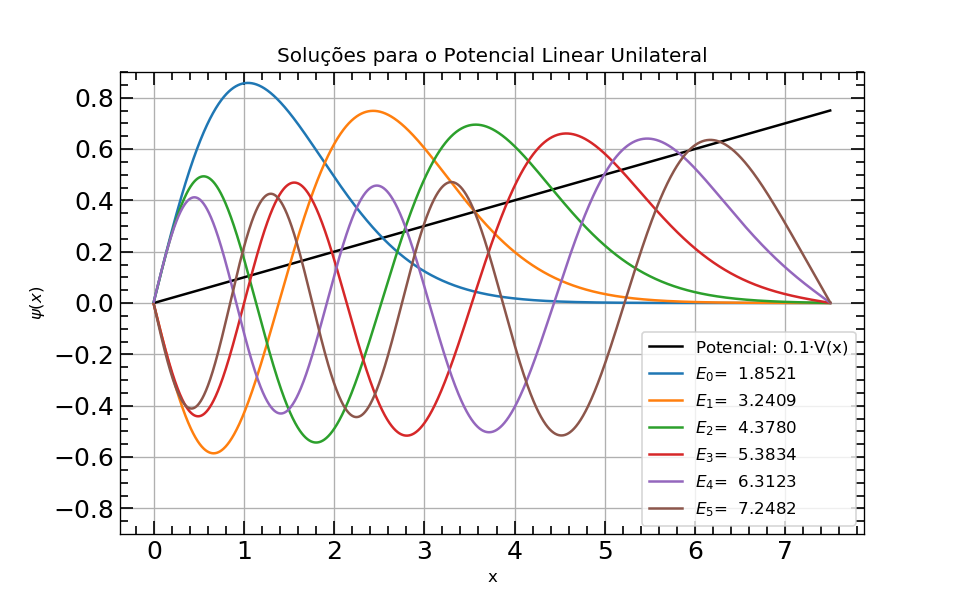

In [25]:
plt.figure(figsize=(8,5))

plt.plot(xo,0.1*Vo,color="black",label="Potencial: 0.1$\cdot$V(x)")
plt.ylim((-0.9,0.9))
for i in range(6):
    if psio[i,N_half-10]<0:
        plt.plot(xo,-psio[i]/np.sqrt(ho),label="$E_{}$={:8.4f}".format(i,Eo[i]))
    else:
        plt.plot(xo,psio[i]/np.sqrt(ho),label="$E_{}$={:8.4f}".format(i,Eo[i]))
    plt.legend()
    plt.title("Soluções para o Potencial Linear Unilateral")
    plt.xlabel("x")
    plt.ylabel("$\psi(x)$")
plt.grid()
opt_plot()

plt.savefig('Soluções para o Potencial Linear Unilateral.png')

$\textbf{OBS}:$ Note que, para as funções de onda, todas as outras funções de onda do caso simétrico correspondem ao do caso unilateral.

### Referências

[1] Mark Newman - Computational Physics (2013,University of Michigan) 

[2] Nicholas J. Giordano; Hisao Nakanishi - Computational Physics (2005,Addison-Wesley,Second Edition) 

[3] Gaël Varoquaux; Emmanuelle Gouillart; Olaf Vahtras; Pierre de Buyl - Scipy Lectures Notes (www.scipy-lectures.org) 

[4] Randall J. LeVeque - Finite Difference Methodsfor Ordinary and PartialDifferential Equations (2007, University of Washington - Seattle, Washington)